<a href="https://colab.research.google.com/github/Yash-10/Higgs-Classification/blob/main/HiggsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2021-03-10 13:03:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  19.7MB/s    in 2m 19s  

2021-03-10 13:05:24 (19.4 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [6]:
!gzip -d HIGGS.csv.gz

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

In [82]:
data_ = pd.read_csv('HIGGS.csv') # Read data from csv to a data frame

In [83]:
data_

,1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00.1,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,1.858587,1.131711,-0.561694,0.000000,0.961000,0.671026,-0.178822,0.000000,1.177604,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,1.002570,-0.636189,-0.367500,0.000000,0.650326,0.511733,-0.182705,0.000000,1.427826,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,1.345027,0.993776,-1.298508,2.214872,1.252707,1.465673,1.262483,0.000000,0.419634,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,0.733136,0.356554,0.354436,2.214872,0.618363,-0.092672,-0.997614,0.000000,0.845596,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


In [84]:
print(f"No. of columns: {len(data_.columns)}\nNo. of rows: {len(data_.index)}")

No. of columns: 29
No. of rows: 10999999


In [85]:
column_names = "lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb"
columns = column_names.split(",")

In [86]:
# Column 2 - 22: Kinematic Properties (Low Level features)
# Column 23 - 29: Functions of above 21 features (High Level features) 
data_.columns = ['label'] + columns
data_

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,1.858587,1.131711,-0.561694,0.000000,0.961000,0.671026,-0.178822,0.000000,1.177604,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,1.002570,-0.636189,-0.367500,0.000000,0.650326,0.511733,-0.182705,0.000000,1.427826,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,1.345027,0.993776,-1.298508,2.214872,1.252707,1.465673,1.262483,0.000000,0.419634,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,0.733136,0.356554,0.354436,2.214872,0.618363,-0.092672,-0.997614,0.000000,0.845596,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


In [87]:
# Select only the first 5000 rows (to prevent session crashing while model training)
data_ = data_.iloc[:5000, :]

In [88]:
drop_cols = data_.columns[-7:]
data_ = data_.drop(columns=list(drop_cols))

In [89]:
data_

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.0,1.517329,-0.218223,-1.491711,0.985417,1.528231,0.903797,-0.638724,0.342765,2.173076,0.664770,1.220106,0.306720,0.000000,0.414466,-1.732030,1.466626,0.000000,0.939308,-0.335256,-0.994669,0.000000
4996,0.0,2.635514,0.295058,-1.045048,2.472771,-0.723998,1.982105,-0.326801,0.750785,2.173076,0.625614,-0.162159,0.125291,0.000000,0.770451,-0.139095,1.365664,2.548224,0.708071,-1.921784,1.675118,0.000000
4997,1.0,2.014747,-0.459767,0.973088,1.126357,0.679822,0.795975,-0.748639,-1.238973,2.173076,1.261931,-0.170901,-0.297592,2.214872,0.888117,1.152548,-0.821763,0.000000,0.961458,0.314346,1.730054,0.000000
4998,0.0,0.790965,0.796652,0.013178,0.266051,-1.041734,0.850390,-1.778478,0.690913,0.000000,0.597286,2.123483,-1.467731,0.000000,1.133987,1.726004,-0.248164,0.000000,1.331924,0.933967,-1.220519,3.101961


In [90]:
data_corr = data_.drop(['label'], axis=1).corr()
print(data_corr)

                           lepton pT   lepton eta  ...   jet 4 phi   jet 4 b-tag
lepton pT                   1.000000     0.002253  ...    0.010314     -0.005391
 lepton eta                 0.002253     1.000000  ...    0.008626      0.003217
 lepton phi                -0.012988     0.000183  ...   -0.083530      0.004518
 missing energy magnitude  -0.127582     0.001556  ...   -0.017260      0.027284
 missing energy phi        -0.013924     0.025125  ...   -0.057610      0.000392
 jet 1 pt                   0.199503    -0.030472  ...    0.002032      0.003979
 jet 1 eta                  0.005437     0.272116  ...   -0.002132     -0.008699
 jet 1 phi                  0.004341    -0.002407  ...   -0.124926     -0.011615
 jet 1 b-tag               -0.016192    -0.011878  ...    0.031707     -0.231363
 jet 2 pt                   0.003739    -0.011287  ...   -0.006473     -0.034986
 jet 2 eta                 -0.009525     0.279495  ...   -0.004845      0.005076
 jet 2 phi                 -

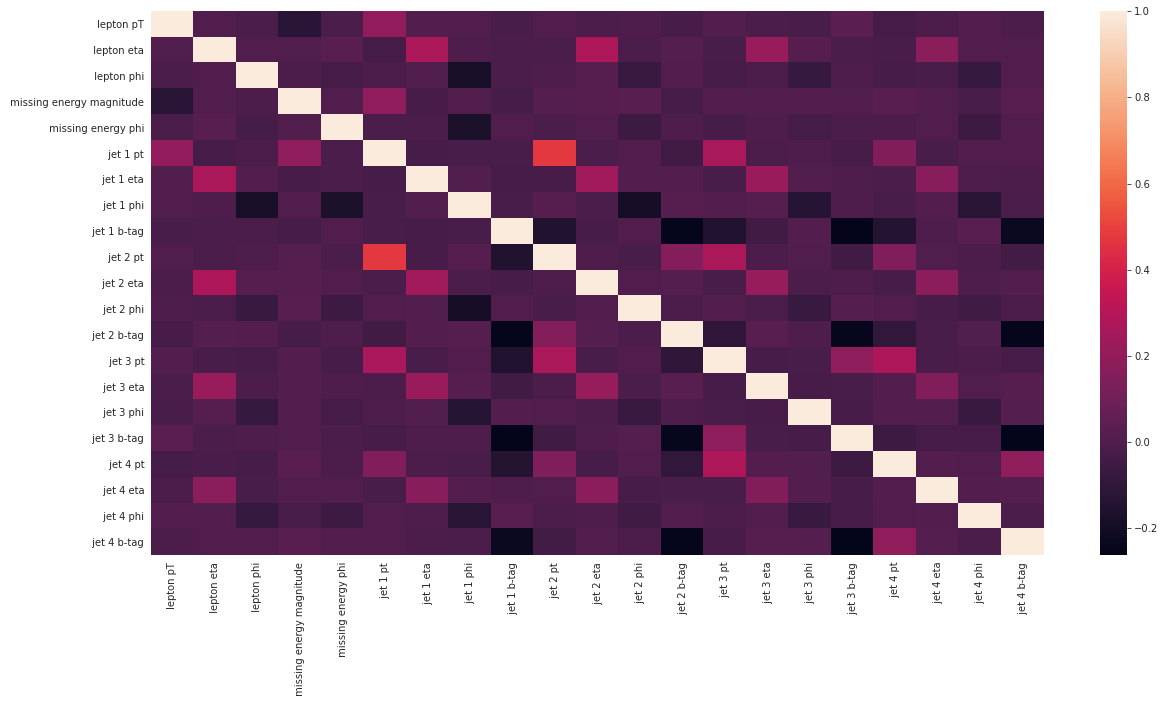

In [91]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_corr)

Text(0, 0.5, 'jet 2 pt')

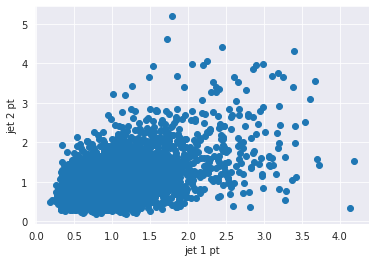

In [92]:
plt.scatter(data_[' jet 1 pt'], data_[' jet 2 pt'])
plt.xlabel('jet 1 pt')
plt.ylabel('jet 2 pt')

In [ ]:
#sns.lmplot(x=' jet 1 pt', y=' jet 2 pt', data=data)

In [93]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

In [95]:
# Custom class creation - Preparing data

class HIGGSDataset(Dataset):
  def __init__(self, csv_file, root):
    self.data_ = pd.read_csv(csv_file)
    self.root = root

  def __len__(self):
    return len(self.data_)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist() # Converts a torch tensor to a python list
    class_0_1 = self.data_.iloc[idx, 1] # 0 for non-reduced csv file, 1 for reduced one. Change this to be dynamic
    values = self.data_.iloc[idx, 1:]
    data_ = np.array(values)
    data_ = data_.astype('float').reshape(-1, 2)
    sample = {'class': class_0_1, 'data': data_}

    return sample

In [96]:
# Instantiating dataset
Higgs_dataset = HIGGSDataset('Higgs_reduced.csv', '/content/') # Using '/content/' for Google Colab

In [97]:
batch_size = 32 # No. of samples to load per batch
shuffle = True # Shuffle to ensure unbiasness in model
dataset_size = len(Higgs_dataset)
val_split = 0.2
split = int(np.floor(val_split * dataset_size))
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Split into train and valid sets
train_indices, valid_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(Higgs_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(Higgs_dataset, batch_size=batch_size, sampler=valid_sampler)

In [105]:
# Creating a Sequential model

# Higgs_model = nn.Sequential(nn.Linear(22, 14),
#                             nn.ReLU(),
#                             nn.Linear(14, 7),
#                             nn.ReLU(),
#                             nn.Linear(7, 1),
#                             nn.Sigmoid())

class Higgs_Model(nn.Module):
    def __init__(self):
        super(Higgs_Model, self).__init__()
        self.fc1 = nn.Linear(22, 14)
        self.fc2 = nn.Linear(14, 6)
        self.fc3 = nn.Linear(6, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sig(x)
        return x

In [106]:
Higgs_model = Higgs_Model()

In [107]:
criterion = nn.BCELoss()
optimizer = optim.Adam(params=Higgs_model.parameters(), lr=0.001)

In [108]:
print(Higgs_model)

Higgs_Model(
  (fc1): Linear(in_features=22, out_features=14, bias=True)
  (fc2): Linear(in_features=14, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=1, bias=True)
  (sig): Sigmoid()
)


Training was terminated after 2 epochs below (using Ctrl + C)

In [116]:
# Training

n_epochs = 100

train_losses = []
valid_losses = []
valid_loss_min = np.inf

for epoch in range(1, n_epochs):
  train_loss = 0
  valid_loss = 0

  # Training
  Higgs_model.train()
  #for data, target in train_loader:
  for i, batch in enumerate(train_loader, 0):
    #data, target = batch
    #print('Training going on...')
    data = batch['data']
    data = data.view(data.shape[0], -1)
    target = batch['class']
    target = target.type(torch.LongTensor)
    #data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = Higgs_model(data.float())
    loss = criterion(output, target.float().unsqueeze(1))
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * data.size(0)
  
  # Validation
  Higgs_model.eval()
  for i, batch in enumerate(validation_loader, 0):
    #data, target = batch
    #print('Testing going on...')
    data = batch['data']
    data = data.view(data.shape[0], -1)
    target = batch['class']
    #target = target.type(torch.LongTensor)
    output = Higgs_model(data.float())
    loss = criterion(output, target.float().unsqueeze(1))
    valid_loss += loss.item() * data.size(0)

  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(validation_loader.sampler)
  
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'Epoch: {epoch}',
        f'Training Loss: {train_loss}',
        f'Valid Loss: {valid_loss}')
  
  if valid_loss < valid_loss_min:
    print(f'Validation Loss decreased: {valid_loss_min} --> {valid_loss}. Saving model...')
    torch.save(Higgs_model.state_dict(), 'higgs_model.pt')
    valid_loss_min = valid_loss

Epoch: 1 Training Loss: 0.0010218871510587633 Valid Loss: 0.0008966296180151403
Validation Loss decreased: inf --> 0.0008966296180151403. Saving model...
Epoch: 2 Training Loss: 0.0008318157298490405 Valid Loss: 0.0007398969354107976
Validation Loss decreased: 0.0008966296180151403 --> 0.0007398969354107976. Saving model...
Epoch: 3 Training Loss: 0.000689235816244036 Valid Loss: 0.0006155074443668127
Validation Loss decreased: 0.0007398969354107976 --> 0.0006155074443668127. Saving model...
Epoch: 4 Training Loss: 0.0005778252449817955 Valid Loss: 0.0005198531104251742
Validation Loss decreased: 0.0006155074443668127 --> 0.0005198531104251742. Saving model...
Epoch: 5 Training Loss: 0.000490402071736753 Valid Loss: 0.00044281289796344937
Validation Loss decreased: 0.0005198531104251742 --> 0.00044281289796344937. Saving model...
Epoch: 6 Training Loss: 0.0004198464376386255 Valid Loss: 0.00038016569428145884
Validation Loss decreased: 0.00044281289796344937 --> 0.00038016569428145884.

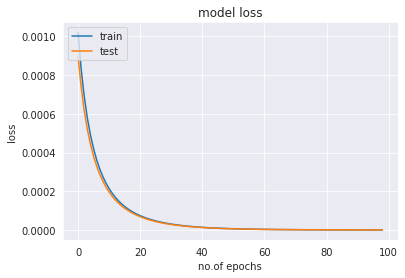

In [117]:
# Plot loss

plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('no.of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [118]:
# Load the model

state_dict = torch.load('/content/higgs_model.pt')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


Accuracy: 0.11675000190734863


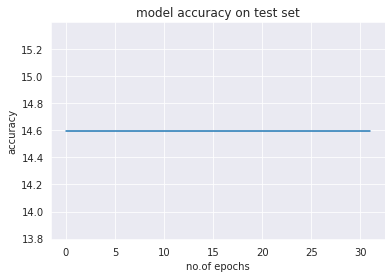

In [119]:
# Model accuracy can be plotted by running this cell

Higgs_model.load_state_dict(state_dict)
accuracy = 0
accuracies = []
for i, batch in enumerate(validation_loader, 0):
  data = batch['data']
  data = data.view(data.shape[0], -1)
  output = Higgs_model(data.float())
  target = batch['class']
  target = target.type(torch.LongTensor)
  top_p, top_class = output.topk(1, dim=1)
  equals = top_class == target.view(*top_class.shape)
  accuracy += torch.mean(equals.type(torch.FloatTensor))
  accuracies.append(accuracy)

print(f'Accuracy: {accuracy / len(train_loader)}')

plt.plot(accuracies)
plt.title('model accuracy on test set')
plt.ylabel('accuracy')
plt.xlabel('no.of epochs')
plt.show()

In [120]:
pip install plot-metric

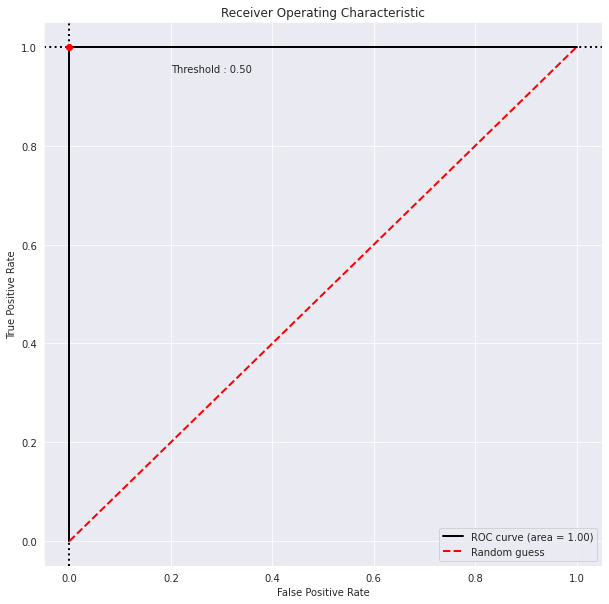

In [121]:
# ROC Curve visualization

for i, batch in enumerate(validation_loader, 0):
  data = batch['data']
  data = data.view(data.shape[0], -1)
  output = Higgs_model(data.float())
  target = batch['class']
  target = target.type(torch.LongTensor)

  break

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
output = output.detach().numpy()
bc = BinaryClassification(output.round(), target, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10, 10))
bc.plot_roc_curve()
plt.show()